# Multimodal PDF RAG - Images and Tables
* Notebook by Adam Lang
* Date: 4/1/2025

# Overview
* In this notebook we will build a RAG application that allows semantic search over PDF files that include images and tables.

# Technology Used
* Docling
  * Multimodal data parsing library.
  * Allows document parsing of: PDF, DOCX, XLSX, HTML, images, and more
  * Advanced PDF understanding incl. page layout, reading order, table structure, code, formulas, image classification, and more
  * https://docling-project.github.io/docling/
* Embeddings
  * BGE embeddings
* Open source LLM: Mistral-7B-Instruct
* LangChain
* Vector DB: Milvus
* HuggingFaceEndpoint

# Architecture

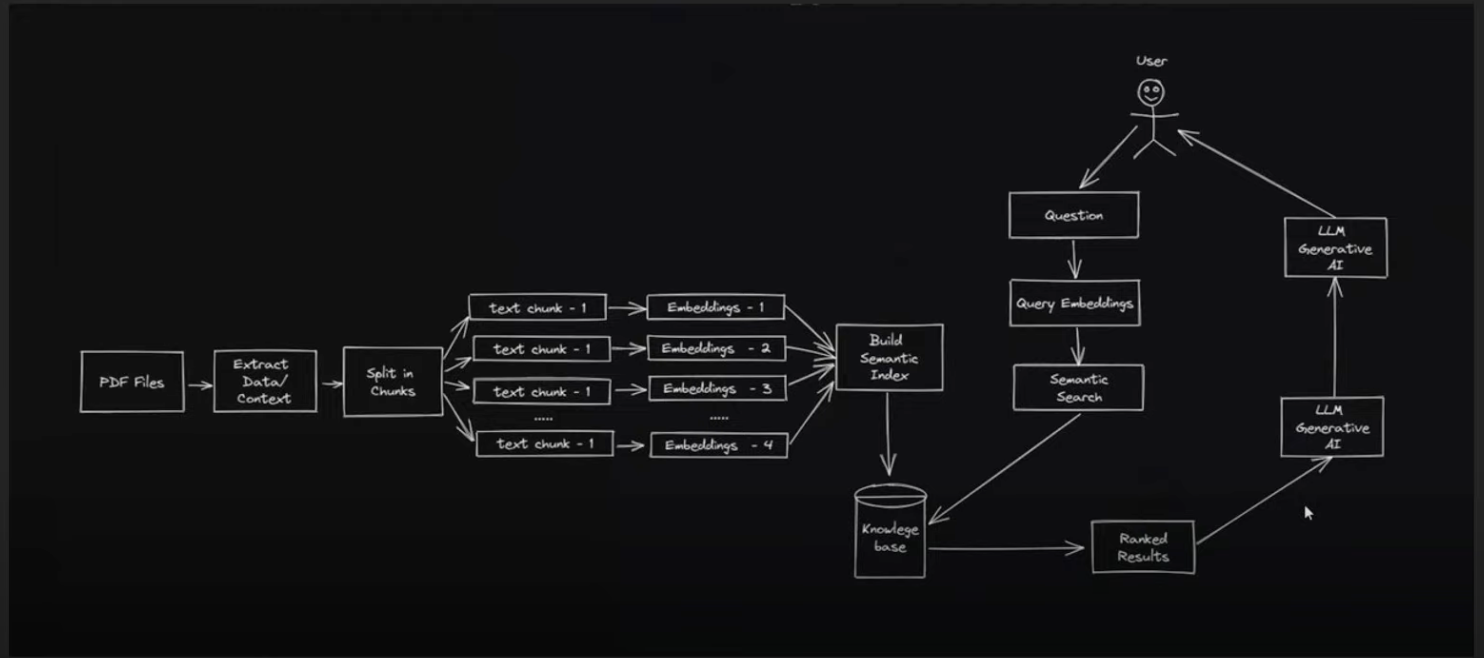

# Install Dependencies

In [ ]:
%%capture
!pip install grpcio>=1.71.0

In [ ]:
%%capture
!pip install -qq docling docling-core langchain-text-splitters langchain-huggingface langchain-milvus

# Get a PDF file
* We can download the llama-2 paper.

In [4]:
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "llama2.pdf"

--2025-04-01 18:12:35--  https://arxiv.org/pdf/2307.09288.pdf
Resolving arxiv.org (arxiv.org)... 151.101.3.42, 151.101.195.42, 151.101.67.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/2307.09288 [following]
--2025-04-01 18:12:35--  http://arxiv.org/pdf/2307.09288
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13661300 (13M) [application/pdf]
Saving to: ‘llama2.pdf’

llama2.pdf          100%[===================>]  13.03M  --.-KB/s    in 0.07s   

2025-04-01 18:12:35 (193 MB/s) - ‘llama2.pdf’ saved [13661300/13661300]



In [6]:
## load the document to a file path
file_path = "/content/llama2.pdf"

# Docling PDF Loader
* The code below will load the PDF and extract information from it.

In [5]:
from typing import Iterator

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document as LCDocument

from docling.document_converter import DocumentConverter

class DoclingPDFLoader(BaseLoader):
    def __init__(self, file_path: str | list[str]) -> None:
        self._file_paths = file_path if isinstance(file_path, list) else [file_path]
        self._converter = DocumentConverter()

    def lazy_load(self) -> Iterator[LCDocument]:
        for source in self._file_paths:
            dl_doc = self._converter.convert(source).document
            text = dl_doc.export_to_markdown()
            yield LCDocument(page_content=text)

# Text Splitter/Chunking
* We will use the langchain default text splitter to chunk the text.
* First we will load the multimodal PDF file, then split it recursively.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

## load PDF into the DoclingPDFLoader
loader = DoclingPDFLoader(file_path=file_path)

## init the Split/chunk text
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

In [8]:
## load docs with loader
docs = loader.load()
## now split the PDF docs
splits = text_splitter.split_documents(docs)

In [9]:
from huggingface_hub import notebook_login
notebook_login()

# Create Embeddings
* I am going to use the `bge-m3` embeddings.
* Model card: https://huggingface.co/BAAI/bge-m3
* These embeddings are unique in that they are know for these 3 important qualities:

1. Multi-Functionality
  * Can simultaneously perform 3 common retrieval functionalities of embedding models:
    * dense retrieval
    * multi-vector retrieval
    * sparse retrieval

2. Multi-Linguality
  * Supports more than 100 working languages

3. Multi-Granularity
  * Ability to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

In [10]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

## load embedding model checkpoint
HF_EMBED_MODEL_ID = "BAAI/bge-m3"

## init embeddings object
embeddings = HuggingFaceEmbeddings(model_name=HF_EMBED_MODEL_ID)

# Vector DB Setup
* We will setup a vector store using Milvus.
* More about Milvus here: https://python.langchain.com/docs/integrations/vectorstores/milvus/

In [12]:
import os
from getpass import getpass

MILVUS_API_KEY = getpass("Enter your Milvus API key: ")

Enter your Milvus API key: ··········


In [16]:
from tempfile import TemporaryDirectory
import os

from langchain_milvus import Milvus

## setup MILVUS environment
MILVUS_URI = os.environ.get(
    "MILVUS_API_KEY", f"{(tmp_dir := TemporaryDirectory()).name}/milvus_demo.db"
)

## Create the vectorstore
vectorstore = Milvus.from_documents(
    splits,
    embeddings,
    drop_old=True,
    connection_args={"uri": MILVUS_URI},
    index_params={"index_type": "FLAT", "metric_type": "L2"},
)

# Load LLM from hugging face and `HuggingFaceEndPoint`
* We will load an open source LLM `Mistral-7B-Instruct-v0.3` from hugging face.
* Model card: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3

* We can use the `HuggingFaceEndPoint` via `langchain_huggingface`.
  * Documentation: https://python.langchain.com/docs/integrations/llms/huggingface_endpoint/

In [17]:
from langchain_huggingface import HuggingFaceEndpoint

## load api key and model checkpoints
HF_API_KEY = os.environ.get("HF_API_KEY")
HF_LLM_MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"

# load hugging face endpoint
llm = HuggingFaceEndpoint(
    repo_id=HF_LLM_MODEL_ID,
    huggingfacehub_api_token=HF_API_KEY,
    temperature=0.1,
)

# Multimodal RAG Pipeline
* Now we can setup a multimodal RAG pipeline with the PDF document in the Milvus vectorstore.

In [19]:
from typing import Iterable
from langchain_core.documents import Document as LCDocument
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

## format
def format_docs(docs: Iterable[LCDocument]):
    return "\n\n".join(doc.page_content for doc in docs)


## create retriever
retriever = vectorstore.as_retriever()

## setup prompt template
prompt = PromptTemplate.from_template(
    "Context information is below.\n---------------------\n{context}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {question}\nAnswer:\n"
)

## create RAG chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Query
* Now query the documents.

In [26]:
rag_chain.invoke("Tell me about Figure 4: Training of Llama 2-Chat:")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


'\nFigure 4: Training of Llama 2-Chat illustrates the training process of the Llama 2-Chat model. It begins with the pretraining of Llama 2 using publicly available online sources. Following this, a supervised fine-tuning process is applied to create an initial version of Llama 2-Chat. Subsequently, the model is refined using Reinforcement Learning with Human Feedback (RLHF) methodologies, specifically through rejection sampling and Proximal Policy Optimization (PPO). The RLHF stage involves the accumulation of iterative reward modeling data in parallel with model enhancements to ensure the reward models remain within distribution.'